In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [ ]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [ ]:
ls

brasilian-houses-to-rent.zip  houses_to_rent.csv     Iris.gsheet  LUS_covid.csv
database.sqlite               houses_to_rent_v2.csv  kaggle.json  Maldata.csv
HeartSounds.zip               Iris.csv               LungCT.zip


In [ ]:
!unzip LungCT.zip

Archive:  LungCT.zip
  inflating: COVID-CT-MetaInfo.xlsx  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png  
  inflating: CT_COVID/2020.01.24.919183-p27-132.png  
  inflating: CT_COVID/2020.01.24.919183-p27-133.png  
  inflating: CT_COVID/2020.01.24.919183-p27-134.png  
  inflating: CT_COVID/2020.01.24.919183-p27-135.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%0.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%1.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%10.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%11.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%12.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%13.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%

In [ ]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

2.4.1


In [ ]:
!kaggle datasets download -d luisblanche/covidct

 91% 78.0M/85.8M [00:00<00:00, 85.1MB/s]
100% 85.8M/85.8M [00:00<00:00, 97.9MB/s]


In [ ]:
!unzip covidct.zip  

Archive:  covidct.zip
replace COVID-CT-MetaInfo.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace COVID-CT-MetaInfo.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: COVID-CT-MetaInfo.xlsx  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png  
  inflating: CT_COVID/2020.01.24.919183-p27-132.png  
  inflating: CT_COVID/2020.01.24.919183-p27-133.png  
  inflating: CT_COVID/2020.01.24.919183-p27-134.png  
  inflating: CT_COVID/2020.01.24.919183-p27-135.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%0.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%1.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%10.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-

In [ ]:
data_root='/content/gdrive/My Drive/kaggle/covidct/'
path_positive_cases = os.path.join('/content/gdrive/My Drive/kaggle/CT_COVID/')
path_negative_cases = os.path.join('/content/gdrive/My Drive/kaggle/CT_NonCOVID/')

In [ ]:
# jpg and png files
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [ ]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [ ]:
df = pd.DataFrame(columns=['height', 'width'])
liste = []

for img_name in os.listdir(path_positive_cases):
    img = cv2.imread(os.path.join(path_positive_cases, img_name))
    liste.append(img.shape[:-1])

for img_name in os.listdir(path_negative_cases):
    img = cv2.imread(os.path.join(path_negative_cases, img_name))
    liste.append(img.shape[:-1])

df['height'] = list(zip(*liste))[0]
df['width'] = list(zip(*liste))[1]

In [ ]:
df.describe()

,height,width
count,746.000000,746.000000
mean,302.553619,425.482574
std,145.210573,188.546038
min,61.000000,115.000000
25%,204.000000,311.250000
50%,291.000000,407.000000
75%,363.750000,512.000000
max,1225.000000,1671.000000


In [ ]:
ls

brasilian-houses-to-rent.zip  database.sqlite        Iris.gsheet
COVID-CT-MetaInfo.xlsx        HeartSounds.zip        kaggle.json
covidct.zip                   houses_to_rent.csv     LungCT.zip
CT_COVID/                     houses_to_rent_v2.csv  LUS_covid.csv
CT_NonCOVID/                  Iris.csv               Maldata.csv


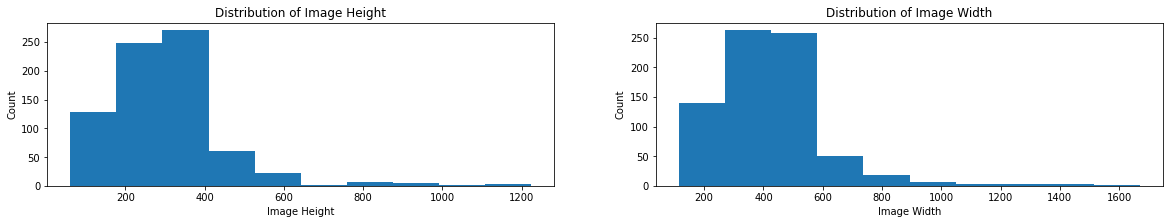

In [ ]:
fig = plt.figure(1, figsize=(20, 3))
plt.subplot(121)
# plot the image height
plt.hist(df['height'])
plt.title('Distribution of Image Height')
plt.xlabel('Image Height')
plt.ylabel('Count')
plt.subplot(122)
plt.hist(df['width'])
plt.title('Distribution of Image Width')
plt.xlabel('Image Width')
plt.ylabel('Count')

plt.show()

In [ ]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


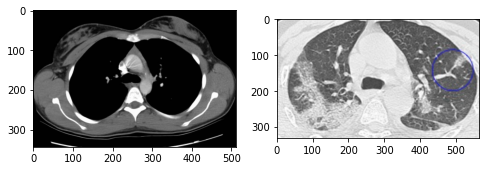

In [ ]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [ ]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

Image COVID Shape (332, 566, 3)
Image Non COVID Shape (344, 512, 3)


Create Train-Test Directory


In [ ]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [ ]:
# Copy Images to test set

# seed random number generator
random.seed(123)
# define ratio of pictures used for testing 
test_ratio = 0.15


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])


CT_COVID 52
CT_NonCOVID 59


In [ ]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])
total_train_covid = len(os.listdir('/content/gdrive/My Drive/kaggle/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/content/gdrive/My Drive/kaggle/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/content/gdrive/My Drive/kaggle/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/content/gdrive/My Drive/kaggle/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 297
Train sets images Non COVID: 338
Test sets images COVID: 52
Test sets images Non COVID: 59


Simple CNN Model

In [ ]:
batch_size = 256
epochs = 250
IMG_HEIGHT = 300
IMG_WIDTH = 300

In [ ]:
"""train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') """

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [ ]:
train_dir = os.path.join('/content/gdrive/My Drive/kaggle/train')
test_dir = os.path.join('/content/gdrive/My Drive/kaggle/test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 635 images belonging to 2 classes.


In [ ]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 111 images belonging to 2 classes.


In [ ]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1)
])

In [ ]:
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 32)       

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
check_point = ModelCheckpoint("./my_model.h5", monitor="val_loss", save_best_only=True)
reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=6)

callbacks_list = [early, check_point, reduce]

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size,
    callbacks=callbacks_list
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/250
1/2 [==============>...............] - ETA: 25s - loss: 0.6990 - accuracy: 0.4472

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored